# Lab: building your first neural network

# 1. Introduction

Congratulations, you made it to your first lab! In this lab, you'll practice everything you have learned during the lecture. We know there is quite a bit of math involved, but don't worry! Using Python and trying things out yourself will actually make a lot of things much more clear! Before we start, let's load some necessary libraries so we can import our data.

Run the cell below to import what we'll need for this lab.

In [1]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os

Using TensorFlow backend.


In this lab, you'll get a bunch of images, and the purpose is to correctly classify these images as "Santa", meaning that Santa is present on the image or "not Santa" meaning that something else is in the images. 

If you have a look at this github repository, you'll notice that the images are simply stored in .jpeg-files and stored under the folder `/data`. Luckily, `keras` had great modules that make importing images stored in this type of format easy. We'll do this for you in the code below.

The images in the `/data` folder have various resultions. We will reshape them so they are all have 64 x 64 pixels.

Run the cell below to build generators that batch our data and their corresponding labels, so that we can read them in effectively during training.

In [2]:
# directory path
train_data_dir = 'data/train'
test_data_dir = 'data/validation'

# get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(64, 64), batch_size=132)

# get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(64, 64), batch_size=790)

# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 132 images belonging to 2 classes.
Found 790 images belonging to 2 classes.


# 2. Inspecting and preparing the data

## 2.1 Look at some images

Note that we have 4 numpy arrays now: `train_images`, `train_labels`, `test_images`, `test_labels`. We'll need to make some changes to the data in order to make them workable, but before we do anything else, let's have a look at some of the images we loaded. We'll look at some images in train_images. You can use `array_to_img()` from `keras.processing.image` on any `train_image` (select any train_image by doing `train_image[index]` to look at it.

Run the cells below to examine some sample images from our dataset. 

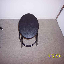

In [3]:
array_to_img(train_images[0])

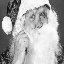

In [4]:
array_to_img(train_images[10])

## 2.2 The shape of the data

Now, let's use `np.shape()` to look at what these numpy arrays look like.* training images

In the cell below, print out the `.shape` of our:
* training images
* training labels
* testing images
* testing labels

In [5]:
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))

(790, 64, 64, 3)
(790, 2)
(132, 64, 64, 3)
(132, 2)


### 2.2.1  `train_images` and `test_images`

Let's start with `train_images`. From the lecture, you might remember that the expected input shape is $n$ x $l$. How does this relate to what we see here?

$l$ denotes the number of observations, or the number of images. The number of images in `train_images` is 790. $n$ is the number of elements in the feature vector for each image, or put differently, $n$ is the number of rows when unrowing the 3 (RGB) 64 x 64 matrices. 

So, translated to this example, we need to transform our `(790, 64, 64, 3)` matrix to a `(64*64*3, 790)` matrix! 

Run the cell below to reshape and transpose our training images.

In [6]:
train_img_unrow = train_images.reshape(790, -1).T

Let's use `np.shape` on the newly created `train_img_unrow` to verify that the shape is correct.

In [7]:
np.shape(train_img_unrow) # Expected Output (12288, 790)

(12288, 790)

Next, let's transform test_images in a similar way. Note that the dimensions are different here! Where we needed to have a matrix shape if $ n$ x $l $ for `train_images`, for `test_images`, we need to get to a shape of $ n$ x $m$. What is $m$ here?

In [8]:
m = 132
test_img_unrow = test_images.reshape(m, -1).T

Now, use `np.shape` to check the shape our `test_img_unrow` variable. 

In [9]:
np.shape(test_img_unrow) # Expected Output (12288, 132)

(12288, 132)

### 2.2.2  `train_labels` and `test_labels`

Earlier, you noticed that `train_labels` and `test_labels` have shapes of $(790, 2)$ and $(132, 2)$ respectively. In the lecture, we expected $1$ x $l$ and $1$ x $m$.

Let's have a closer look. Examine `train_labels` in the cell below.

In [10]:
train_labels

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       ..., 
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]], dtype=float32)

Looking at this, it's clear that for each observation (or image), train_labels doesn't simply have an output of 1 or 0, but a pair either `[0,1]` or `[1,0]`.

Having this information, we still don't know which pair correcponds with `santa` versus `not_santa`. Luckily, what this was stored using `keras.preprocessing_image`, and you can get more info using the command `train_generator.class_indices`.

In [11]:
train_generator.class_indices

{'not_santa': 0, 'santa': 1}

Index 0 (the first column) represents `not_santa`, index 1 represents `santa`. Select one of the two columns and transpose the result such that you get a $1$ x $l$ and $1$ x $m$ vector respectively, and value `1` represents `santa`

In [12]:
train_labels_final = train_labels.T[[1]]

In [13]:
np.shape(train_labels_final)

(1, 790)

In [14]:
test_labels_final = test_labels.T[[1]]

In [15]:
np.shape(test_labels_final)

(1, 132)

As a final sanity check, look at an image and the corresponding label, so we're sure that santa is indeed stored as `1`.

- First, use `array_to_image` again on the original `train_images` with index 140 to look at this particular image.
- Use train_labels_final to get the 240th label.

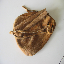

In [16]:
array_to_img(train_images[240])

In [17]:
train_labels_final[:,240]

array([ 0.], dtype=float32)

This seems to be correct! Feel free to try out other indices as well.

### 2.2.3 Lastly, you'll want to standardize the data.

Remember that each RGB pixel in an image takes a value between 0 and 255. In Deep Learning, it is very common to standardize and/or center your data set. For images, a common thing that is done is to make sure each pixel value is between 0 and 1. This can be done by dividing the entire matrix by 255. Do this here for the `train_img_unrow` and `test_img_unrow`.

In [18]:
train_img_final = train_img_unrow/255.
test_img_final = test_img_unrow/255.

type(test_img_unrow)

numpy.ndarray

In what follows, we'll work with `train_img_final`, `test_img_final`, `train_labels_final`, `test_labels_final`.

# 3. Building a logistic regression-based neural network

## 3.1 Math recap

Now we can go ahead and build our own basic logistic regression-based neural network to disctinguish images with Santa from images without Santa. You've seen in the lecture that logistic regression can actually be represented a a very simple neural network.

Remember that we defined that, for each $x^{(i)}$:


$$ \mathcal{L}(\hat y ^{(i)}, y^{(i)}) =  - \big( y^{(i)} \log(\hat y^{(i)}) + (1-y^{(i)} )  \log(1-\hat y^{(i)})\big)$$

$$\hat{y}^{(i)} = \sigma(z^{(i)}) = \frac{1}{1 + e^{-(z^{(i)})}}$$ 

$$z^{(i)} = w^T x^{(i)} + b$$

The cost function is then given by:
$$J(w,b) = \dfrac{1}{l}\displaystyle\sum^l_{i=1}\mathcal{L}(\hat y^{(i)}, y^{(i)})$$

In the remainder of this lab, you'll do the following:

   - You'll learn how to initialize the parameters of the model
   - You'll perform forward propagation, and calculate the current loss
   - You'll perform backward propagation (which is basically calculating the current gradient)
   - You'll update the parameters (gradient descent)

## 3.2 Parameter initialization

$w$ and $b$ are the unknown parameters to start with. We'll initialize them as 0.
- remember that $b$ is a scalar
- $w$ however, is a vector of shape $n$ x $1$, with $n$ being `horiz_pixel x vertic_pixel x 3`

### 3.2.1 initialize b

 Initialize b as a scalar with value 0.

In [19]:
b = 0

### 3.2.2 Initialize w

Create a function `init_w(n)` such that when n is filled out, you get a vector with zeros that has a shape $n$ x $1$.

In [20]:
def init_w(n):
    w = np.zeros((n,1))
    return w

Now, call the `init_w` function and set `n` equal to the size of our images, which is `64*64*3` (64 pixels tall * 64 pixels wide * 3 color channels, RGB)

In [21]:
w = init_w(64*64*3)

## 3.3 forward propagation

Forward Propagation:
- You get `x`
- You compute `y_hat`: 
$$ (\hat y^{(1)}, \hat y^{(2)}, \ldots , \hat y^{(l)})= \sigma(w^T x + b) = \Biggr(\dfrac{1}{1+exp(w^T x^{(1)}+ b)},\ldots, \dfrac{1}{1+exp(w^T x^{(l)}+ b)}\Biggr) $$
- You calculate the `cost` function: $J(w,b) = -\dfrac{1}{l}\displaystyle\sum_{i=1}^{l}y^{(i)}\log(\hat y^{(i)})+(1-y^{(i)})\log(1-\hat y^{(i)})$

Here are the two formulas you will be using to compute the gradients. Don't be scared off by the mathematics. The long formulas are just to show that this corresponds with what we derived in the lectures!

$$ \frac{dJ(w,b)}{dw} = \displaystyle\frac{1}{l}\displaystyle\sum^l_{i=1} \frac{d\mathcal{L}(\hat y^{(i)}, y^{(i)})}{dw}= \displaystyle\frac{1}{l}\displaystyle\sum^l_{i=1} x^{(i)} dz^{(i)}  = \displaystyle\frac{1}{l}\displaystyle\sum^l_{i=1} x^{(i)}(\hat y^{(i)}-y^{(i)})  = \frac{1}{l}x(\hat y-y)^T$$

$$ \frac{dJ(w,b)}{db} = \displaystyle\frac{1}{l}\displaystyle\sum^l_{i=1} \frac{d\mathcal{L}(\hat y^{(i)}, y^{(i)})}{db}= \displaystyle\frac{1}{l}\displaystyle\sum^l_{i=1} dz^{(i)}  = \displaystyle\frac{1}{l}\displaystyle\sum^l_{i=1} (\hat y^{(i)}-y^{(i)})$$

We've defined this function for you, since it's a bit complex and we haven't deeply covered forward and back propagation yet.  Don't worry, you'll be implementing a more complex version of this from scratch in the next lab!

In [22]:
def propagation(w, b, x, y):
    l = x.shape[1]
    # Get prediction
    y_hat = 1/(1 + np.exp(- (np.dot(w.T,x)+b)))       
    # Compute cost
    cost = -(1/l) * np.sum(y * np.log(y_hat)+(1-y)* np.log(1-y_hat)) 
    # Get the derivative of weights
    dw = (1/l) * np.dot(x,(y_hat-y).T)
    db = (1/l) * np.sum(y_hat-y)
    return dw, db, cost

Now, call the function we just wrote to get values for `dw`, `db`, and `cost`.

In [23]:
dw, db, cost = propagation(w, b, train_img_final, train_labels_final)

In [24]:
print(dw)

print(db)

print(cost)

[[-0.05784065]
 [-0.05436336]
 [-0.06367089]
 ..., 
 [-0.07482998]
 [-0.06692231]
 [-0.07262596]]
-0.0113924050633
0.69314718056


## 3.4 Optimization

Next, in the optimization step, we have to update $w$ and $b$ as follows:

$$w := w - \alpha * dw$$
$$b := b - \alpha * db$$

where $\alpha$ is a scalar value called the **_Learning Rate_**.

Note that this `optimization` function also takes in the propagation function. It loops over the `propagation` function in each iteration, and updates both $w$ and $b$ right after that! 

In [25]:
def optimization(w, b, x, y, num_iterations, learning_rate, print_cost = False):
    
    costs = []
    
    for i in range(num_iterations):
        dw, db, cost = propagation(w, b, x, y)    
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # Record the costs and print them every 50 iterations
        if i % 50 == 0:
            costs.append(cost)
        if print_cost and i % 50 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    return w, b, costs

In [26]:
w, b, costs = optimization(w, b, train_img_final, train_labels_final, num_iterations= 151, learning_rate = 0.0001, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 50: 0.675005
Cost after iteration 100: 0.668414
Cost after iteration 150: 0.662114


## 3.5 Make label predictions: Santa or not?

Next, let's create a function that makes label predictions. We'll later use this when we will look at our Santa pictures. What we want, is a label that is equal to 1 when the predicted $y$ is bigger than 0.5, and 0 otherwise.

In [27]:
def prediction(w, b, x):
    l = x.shape[1]
    y_prediction = np.zeros((1,l))
    w = w.reshape(x.shape[0], 1)
    y_hat = 1/(1 + np.exp(- (np.dot(w.T,x)+b))) 
    p = y_hat
    
    for i in range(y_hat.shape[1]):
        if (y_hat[0,i] > 0.5): 
            y_prediction[0,i] = 1
        else:
            y_prediction[0,i] = 0
    return y_prediction

Let's try this out on a small example. Make sure to have 4 predictions in your output here!

In [28]:
w = np.array([[0.035],[0.123],[0.217]])
b = 0.2
x = np.array([[0.2,0.4,-1.2,-2],[1,-2.,0.1,-1],[0.2,0.4,-1.2,-2]])

prediction(w,b,x)

array([[ 1.,  1.,  0.,  0.]])

## 3.6 The overall model

Now, let's build the overall model!

In [29]:
def model(x_train, y_train, x_test, y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):

    b = 0
    w = init_w(np.shape(x_train)[0]) 

    # Gradient descent (≈ 1 line of code)
    w, b, costs = optimization(w, b, x_train, y_train, num_iterations, learning_rate, print_cost)
    
    y_pred_test = prediction(w, b, x_test)
    y_pred_train = prediction(w, b, x_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

    output = {"costs": costs,
         "y_pred_test": y_pred_test, 
         "y_pred_train" : y_pred_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return output

In [30]:
output = model(train_img_final, train_labels_final, test_img_final, test_img_final, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 50: 0.880402
Cost after iteration 100: 0.763331
Cost after iteration 150: 0.628797
Cost after iteration 200: 0.518186
Cost after iteration 250: 0.442320
Cost after iteration 300: 0.391254
Cost after iteration 350: 0.354488
Cost after iteration 400: 0.326262
Cost after iteration 450: 0.304070
Cost after iteration 500: 0.287473
Cost after iteration 550: 0.276690
Cost after iteration 600: 0.269139
Cost after iteration 650: 0.262364
Cost after iteration 700: 0.255995
Cost after iteration 750: 0.249976
Cost after iteration 800: 0.244271
Cost after iteration 850: 0.238848
Cost after iteration 900: 0.233684
Cost after iteration 950: 0.228756
Cost after iteration 1000: 0.224046
Cost after iteration 1050: 0.219537
Cost after iteration 1100: 0.215215
Cost after iteration 1150: 0.211066
Cost after iteration 1200: 0.207080
Cost after iteration 1250: 0.203246
Cost after iteration 1300: 0.199553
Cost after iteration 1350: 0.195995
Cost after iter

# Conclusion

As you can see, this model is fairly complex to build from scratch, but isn't really capable of a complex task like determining if an image contains Santa or not, because this problem is not **_Linearly Separable_**.  This is a problem we can solve by adding more layers and building a **_Multi-Layer Perceptron_** in our next lab--great job!